### This notebook is used to generate results for the pairwise consistency benchmarking 

In [1]:
## import statements
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

In [2]:
## Read in pairwise consistency results 

dir_path="/private/groups/patenlab/mira/centrolign/analysis/pairwise_consistency/"

# All matching files
files = glob.glob(os.path.join(dir_path,
    "HPRC_r2_QCv2_chr*_pairwise_consistency.txt"))

# Read all TSVs
df_list = []
for f in files:
    
    # Skip empty files
    if os.path.getsize(f) == 0:
        continue

    df = pd.read_csv(f, sep="\t")
    
    # extract chromosome name from filename
    base = os.path.basename(f)
    chr_name = base.split("_")[3]
    df["chr"] = chr_name  # optional: track which file each row came from
    df_list.append(df)

# combined to a single df
df=pd.concat(df_list, ignore_index=True)

df.head()

,sample1,sample2,intersection,union,aligned_intersection,aligned_union,jaccard,aligned_jaccard,num_pos_ind,num_pos_dir,chr
0,HG00097.1,HG00099.2,3747091,5051067,279734,819594,0.741841,0.341308,4545319,4252839,chr16
1,HG00097.1,HG00128.2,4605794,6434286,417342,1148036,0.715821,0.363527,5728223,5311857,chr16
2,HG00097.1,HG00133.1,4003267,5901190,768940,1557755,0.678383,0.493621,5115783,4788674,chr16
3,HG00097.1,HG00133.2,4082018,5006437,193584,555179,0.815354,0.348688,4661015,4427440,chr16
4,HG00146.1,HG00097.1,4638337,5635312,88121,483712,0.823084,0.182177,5220894,5052755,chr16


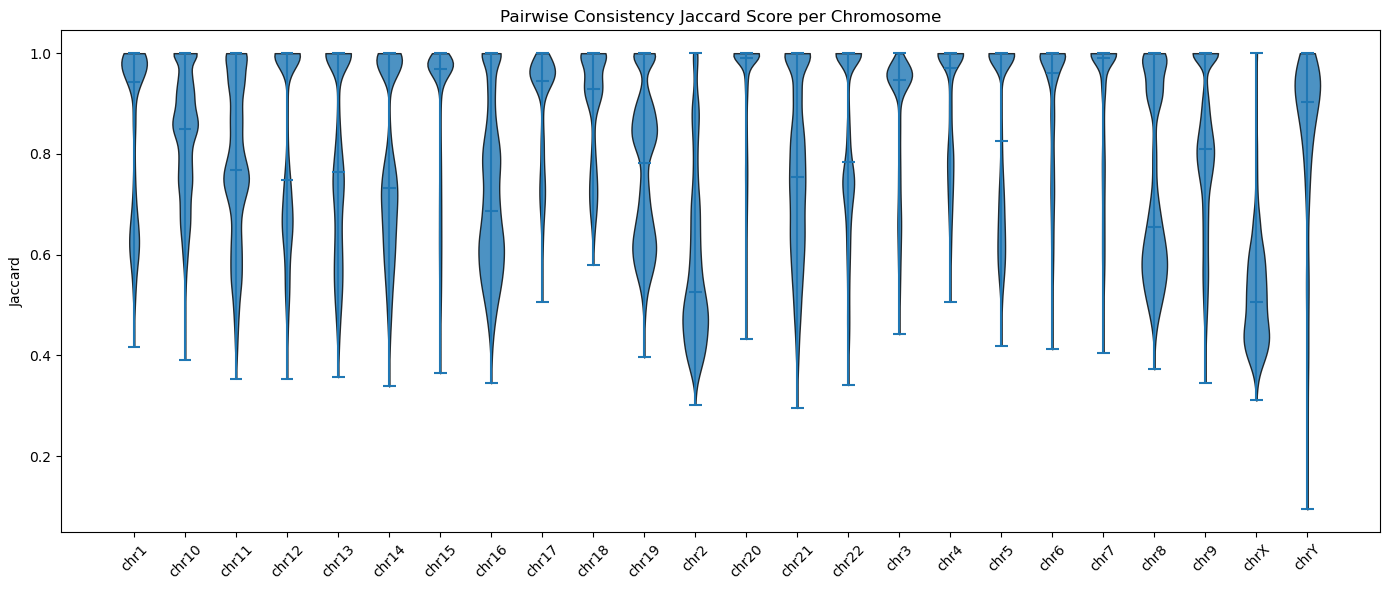

In [3]:
import matplotlib.pyplot as plt

# group your dataframe by chromosome
groups = [df[df["chr"] == c]["jaccard"].values
          for c in sorted(df["chr"].unique())]

chromosomes = sorted(df["chr"].unique())

plt.figure(figsize=(14, 6))

# make the violin plot
parts = plt.violinplot(groups, showmeans=False, showextrema=True, showmedians=True)

# prettier styling (optional)
for pc in parts['bodies']:
    pc.set_facecolor('#1f77b4')
    pc.set_edgecolor('black')
    pc.set_alpha(0.8)

plt.xticks(range(1, len(chromosomes) + 1), chromosomes, rotation=45)
plt.ylabel("Jaccard")
plt.title("Pairwise Consistency Jaccard Score per Chromosome")
plt.tight_layout()
plt.show()


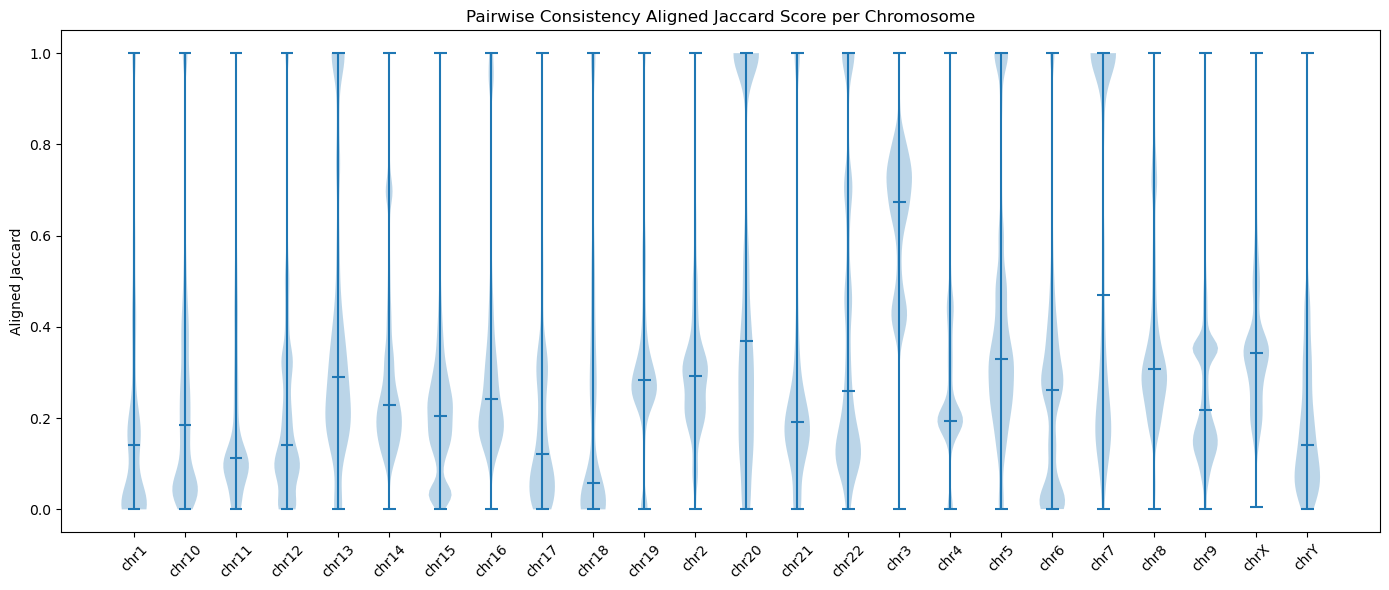

In [4]:
import matplotlib.pyplot as plt

# group your dataframe by chromosome
groups = [df[df["chr"] == c]["aligned_jaccard"].values
          for c in sorted(df["chr"].unique())]

# Drop NAs
groups = [df[df["chr"] == c]["aligned_jaccard"].dropna().values
          for c in chromosomes]

chromosomes = sorted(df["chr"].unique())

plt.figure(figsize=(14, 6))

# make the violin plot
parts = plt.violinplot(groups, showmeans=False, showextrema=True, showmedians=True)

plt.xticks(range(1, len(chromosomes) + 1), chromosomes, rotation=45)
plt.ylabel("Aligned Jaccard")
plt.title("Pairwise Consistency Aligned Jaccard Score per Chromosome")
plt.tight_layout()
plt.show()

In [5]:
# Read in pairwise distance values to the dataframe 
# Directory containing CSV files
pairwise_dist_dir = "/private/groups/patenlab/mira/centrolign/batch_submissions/centrolign/release2_QC_v2/all_pairs/distance_matrices/"  # this should be a folder path

# Collect all matching files
files = glob.glob(os.path.join(pairwise_dist_dir, "*_r2_QC_v2_centrolign_pairwise_distance.csv"))

all_dfs = []

for f in files:
    # Extract chr from filename
    # e.g. filename: "chr3_r2_QC_v2_centrolign_pairwise_distance.csv"
    basename = os.path.basename(f)
    chr_val = basename.split("_")[0]   # 'chr3'

    # Read CSV
    df_chr = pd.read_csv(f, header=None, names=['sample1', 'sample2', 'pairwise_dist'])
    df_chr["chr"] = chr_val

    all_dfs.append(df_chr)

# Combine into one dataframe
dist_df = pd.concat(all_dfs, ignore_index=True)

## Combine pairwise dists and SVs into single dataframe 
# Sort sample pairs so ordering doesn't matter
df_dist_sorted = dist_df.copy()
df_dist_sorted[['sample1', 'sample2']] = np.sort(df_dist_sorted[['sample1', 'sample2']], axis=1)

df_pairwise_consis = df.copy()
df_pairwise_consis[['sample1', 'sample2']] = np.sort(df_pairwise_consis[['sample1', 'sample2']], axis=1)

# Merge on sample1, sample2, AND chr
df = df_pairwise_consis.merge(df_dist_sorted, on=['sample1', 'sample2', 'chr'], how='left')

df.head()

,sample1,sample2,intersection,union,aligned_intersection,aligned_union,jaccard,aligned_jaccard,num_pos_ind,num_pos_dir,chr,pairwise_dist
0,HG00097.1,HG00099.2,3747091,5051067,279734,819594,0.741841,0.341308,4545319,4252839,chr16,0.719148
1,HG00097.1,HG00128.2,4605794,6434286,417342,1148036,0.715821,0.363527,5728223,5311857,chr16,0.685886
2,HG00097.1,HG00133.1,4003267,5901190,768940,1557755,0.678383,0.493621,5115783,4788674,chr16,0.566376
3,HG00097.1,HG00133.2,4082018,5006437,193584,555179,0.815354,0.348688,4661015,4427440,chr16,0.800669
4,HG00097.1,HG00146.1,4638337,5635312,88121,483712,0.823084,0.182177,5220894,5052755,chr16,0.863991


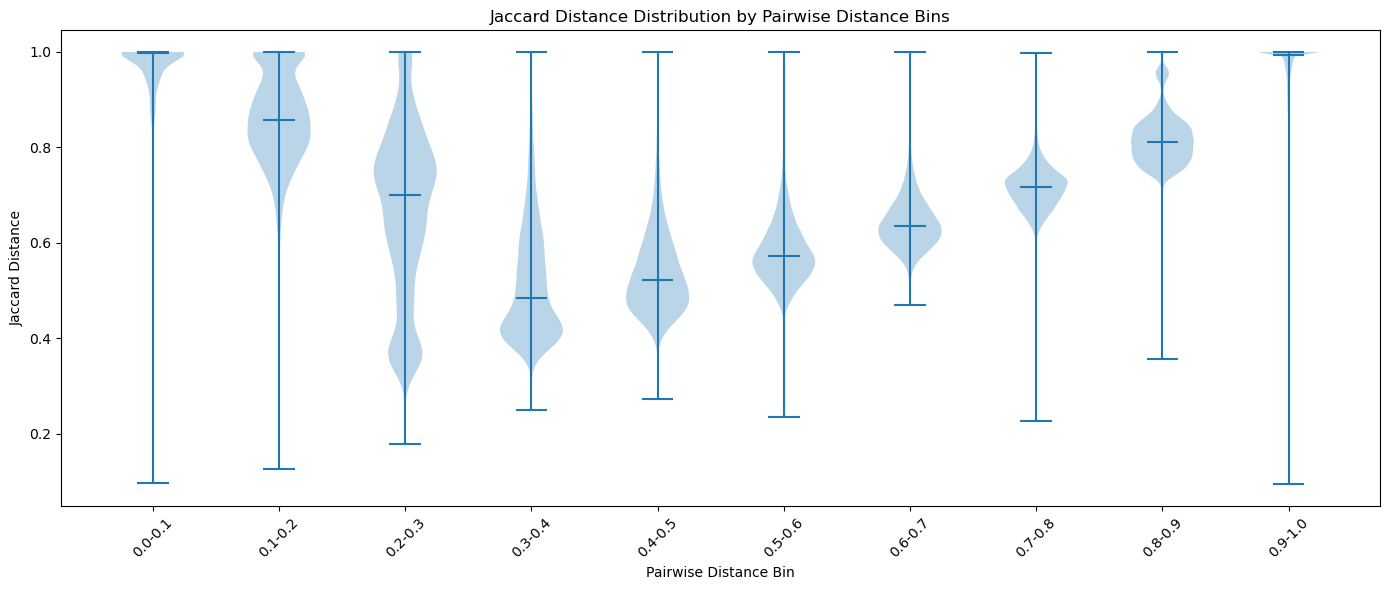

In [18]:
# Across all chromosomes, plot the distribution of pairwise consistency within each bin 

# define bins and labels
bins = np.arange(0, 1.1, 0.1)       # 0.0, 0.1, 0.2, ... 1.0
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

df["dist_bin"] = pd.cut(df["pairwise_dist"], bins=bins, labels=labels, include_lowest=True)

# remove NAs
groups = [
    df.loc[df["dist_bin"] == label, "jaccard"].dropna().values
    for label in labels
]

plt.figure(figsize=(14, 6))

plt.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)

plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
plt.ylabel("Jaccard Distance")
plt.xlabel("Pairwise Distance Bin")
plt.title("Jaccard Distance Distribution by Pairwise Distance Bins")

plt.tight_layout()
plt.show()

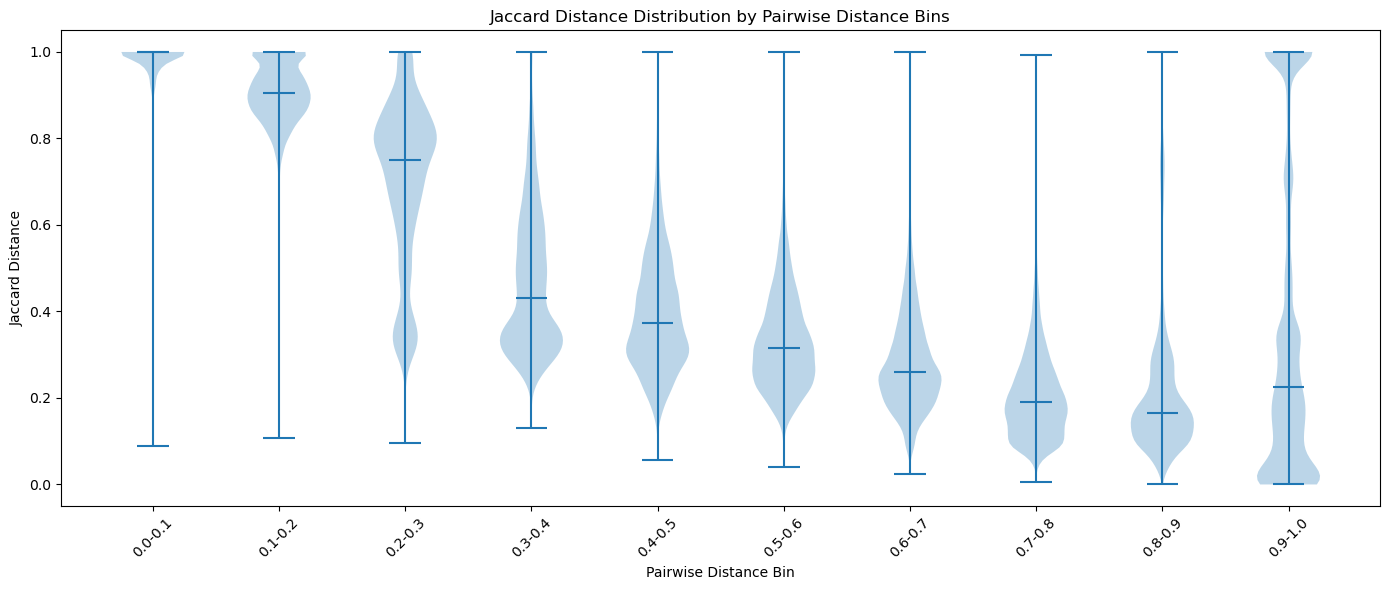

In [19]:
# Across all chromosomes, plot the distribution of pairwise consistency within each bin 

# define bins and labels
bins = np.arange(0, 1.1, 0.1)       # 0.0, 0.1, 0.2, ... 1.0
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

df["dist_bin"] = pd.cut(df["pairwise_dist"], bins=bins, labels=labels, include_lowest=True)

# remove NAs
groups = [
    df.loc[df["dist_bin"] == label, "aligned_jaccard"].dropna().values
    for label in labels
]

plt.figure(figsize=(14, 6))

plt.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)

plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
plt.ylabel("Jaccard Distance")
plt.xlabel("Pairwise Distance Bin")
plt.title("Jaccard Distance Distribution by Pairwise Distance Bins")

plt.tight_layout()
plt.show()

In [ ]:
# Pull out a few examples for synteny plots
subset = df[
    (df["chr"] == "chr6") &
    (df["dist_bin"] == "0.3-0.4") &
    (df["jaccard"] < 0.6)
]

print(subset.head())


          sample1    sample2  intersection    union  aligned_intersection  \
219392  HG00253.1  HG02486.2       2850824  5266379               1502860   
224299  HG00741.2  NA19700.1       2575868  4517177               1559079   
225834  HG01167.2  NA19700.1       2587632  4559339               1527548   
225836  HG01167.2  NA19835.1       2634827  4426107               1598283   
226183  HG01258.1  HG02083.2       2067307  4379079                509035   

        aligned_union   jaccard  aligned_jaccard  num_pos_ind  num_pos_dir  \
219392        2527347  0.541325         0.594639      4016714      4100489   
224299        2429578  0.570238         0.641708      3490176      3602869   
225834        2394617  0.567545         0.637909      3490176      3656795   
225836        2385599  0.595292         0.669971      3465449      3595485   
226183        1396515  0.472087         0.364504      3545250      2901136   

         chr  pairwise_dist dist_bin  
219392  chr6       0.350409  

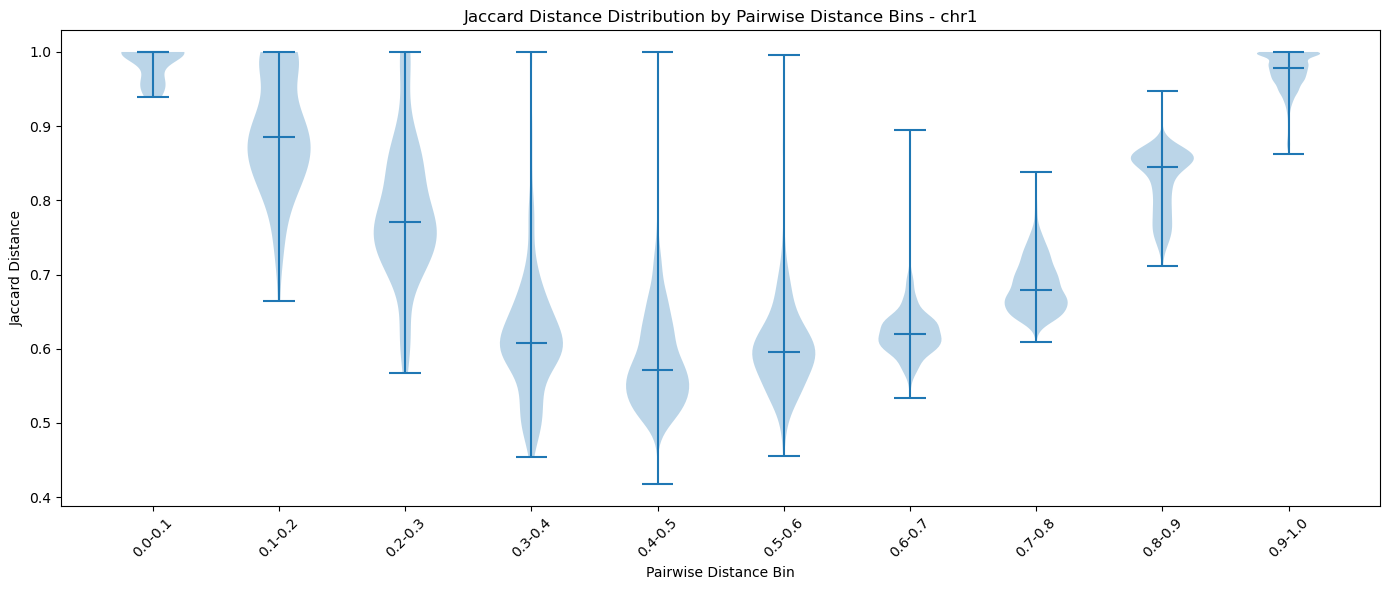

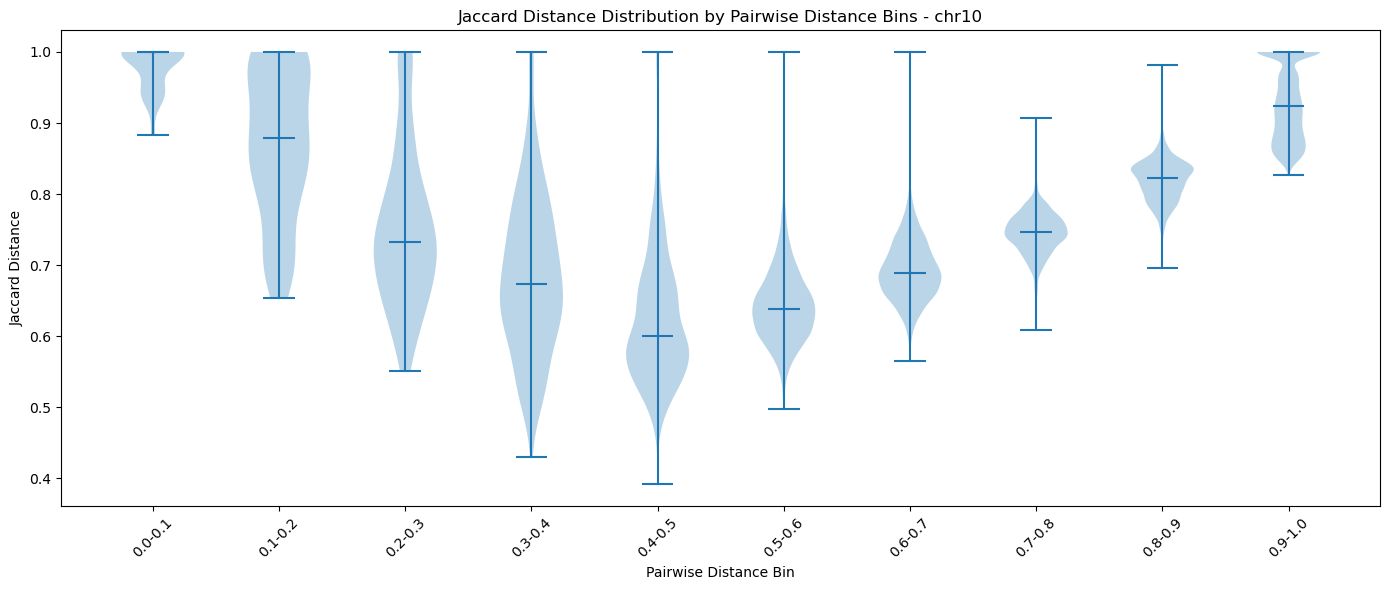

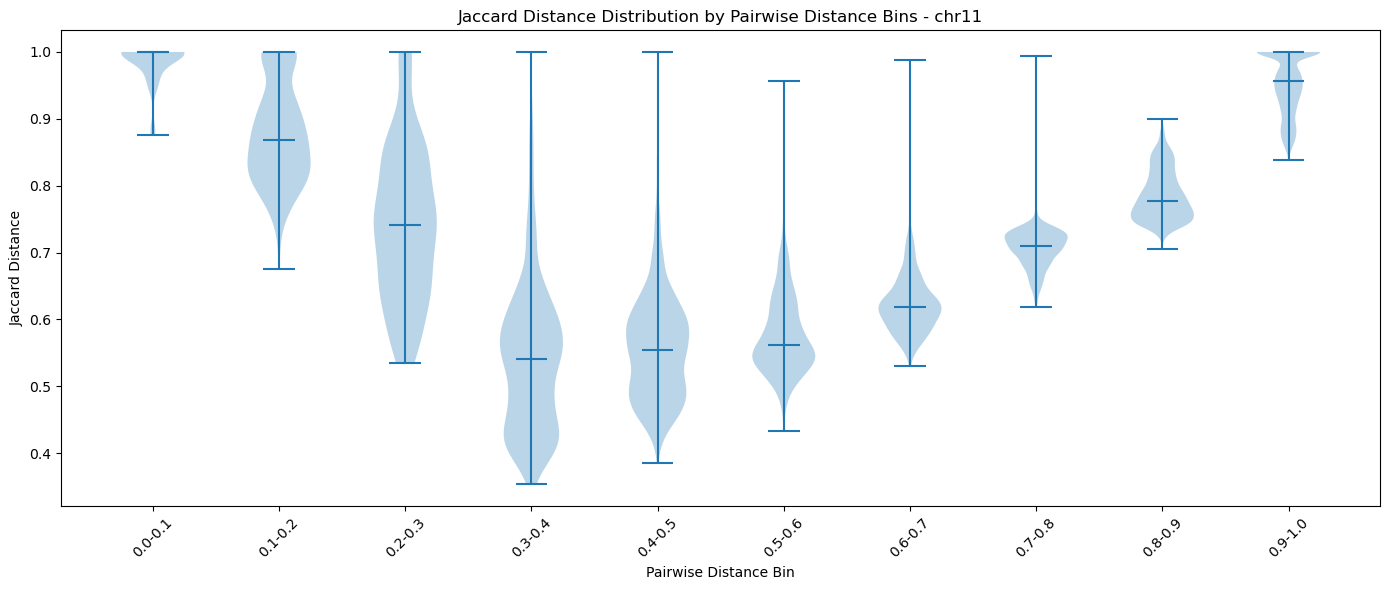

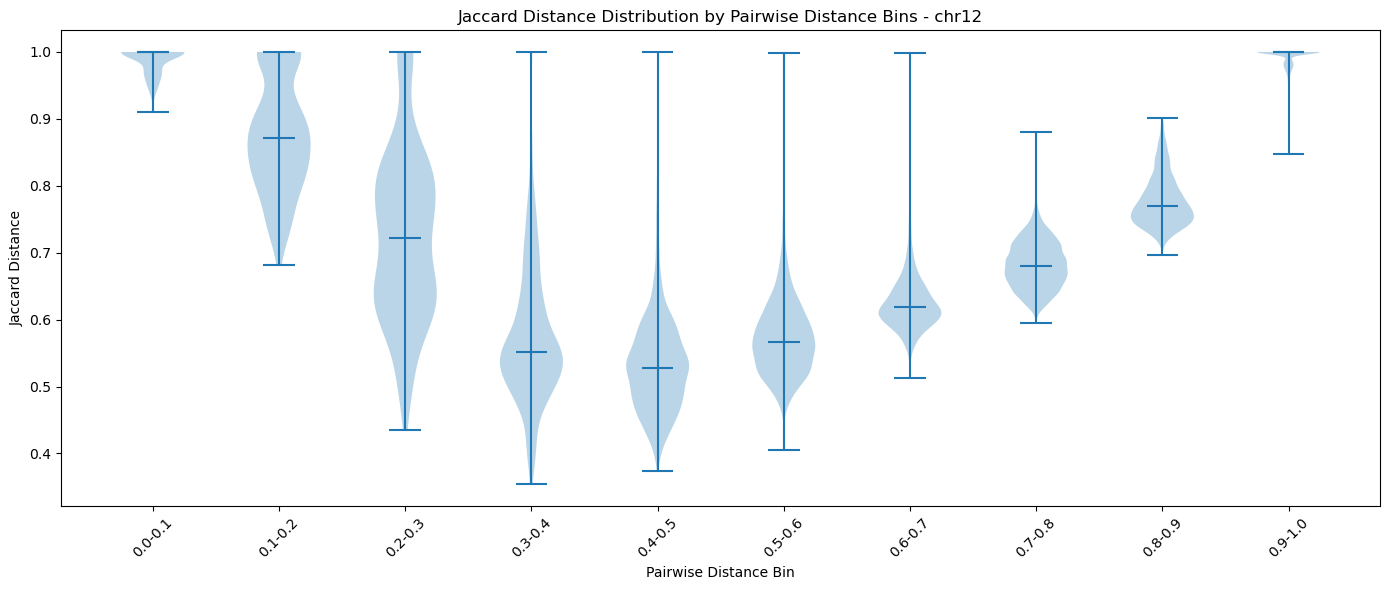

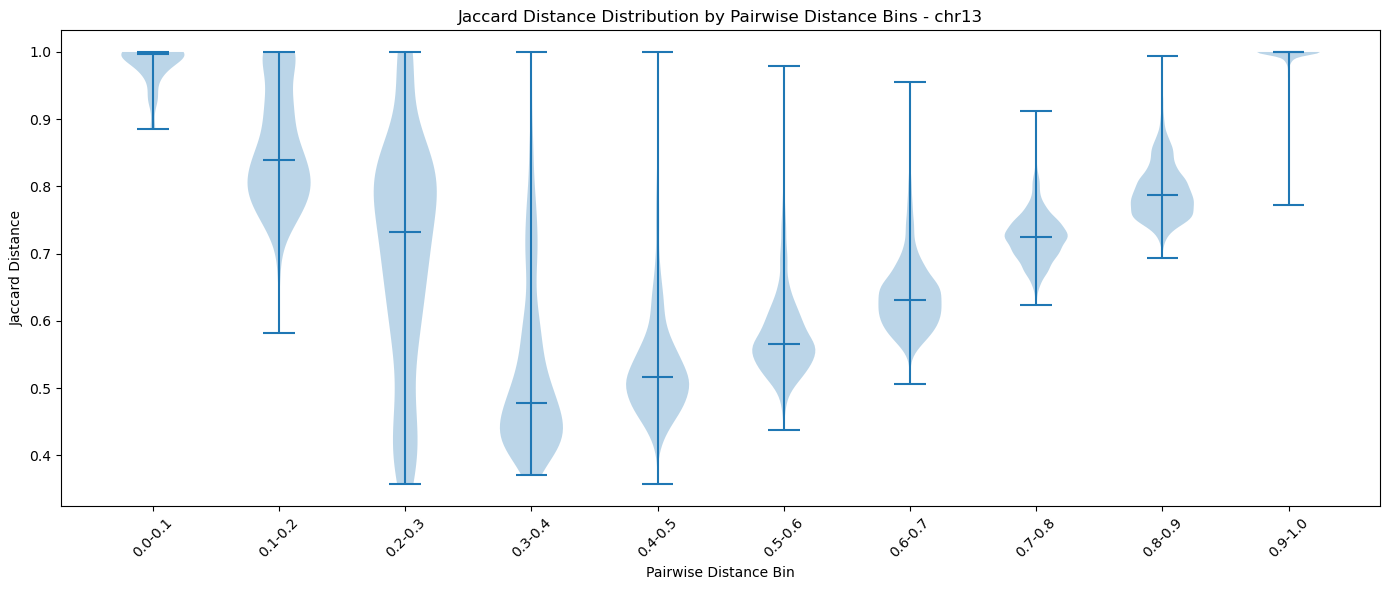

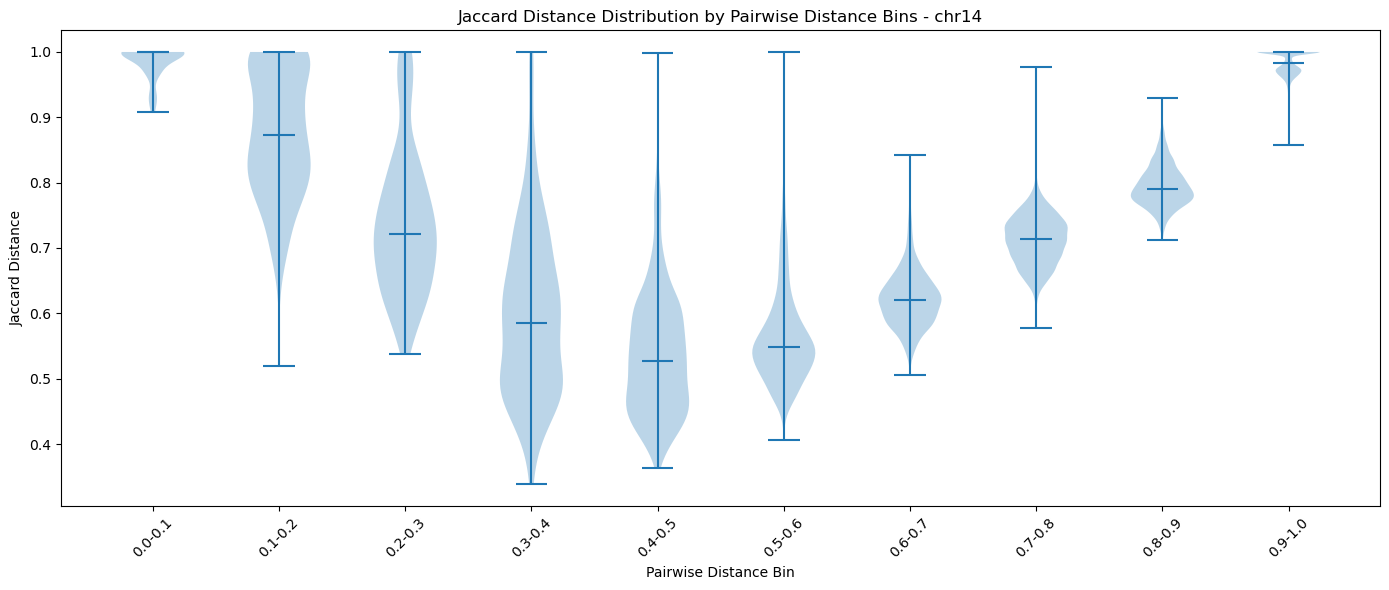

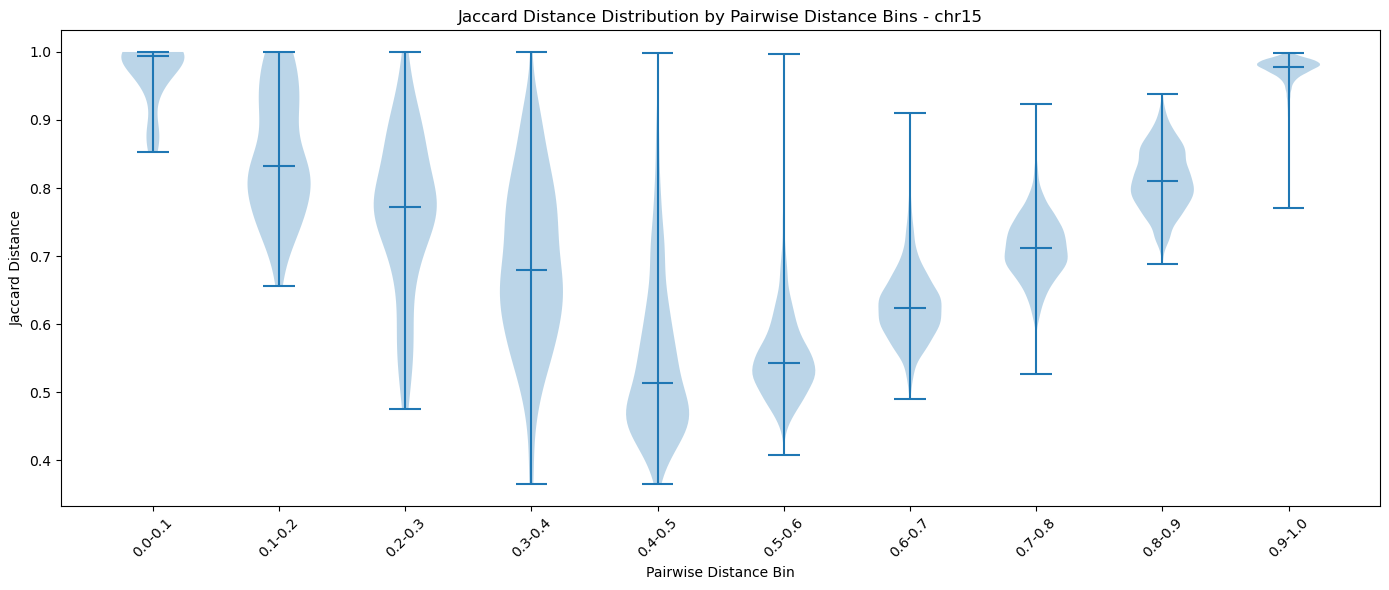

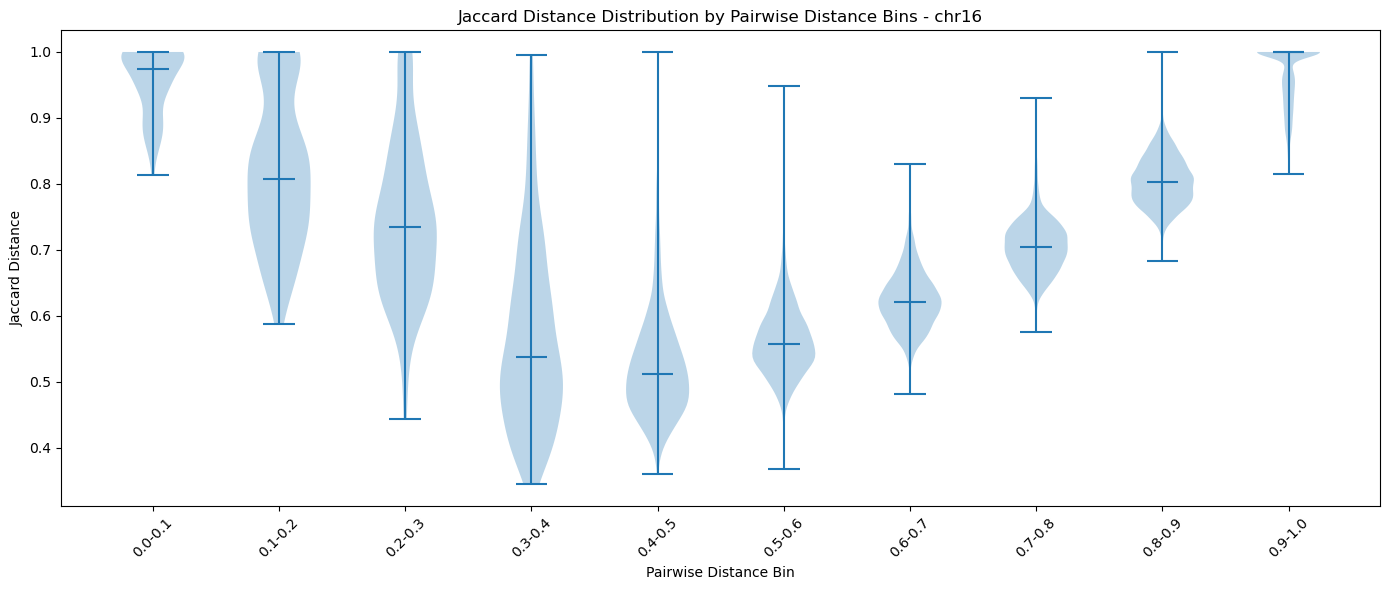

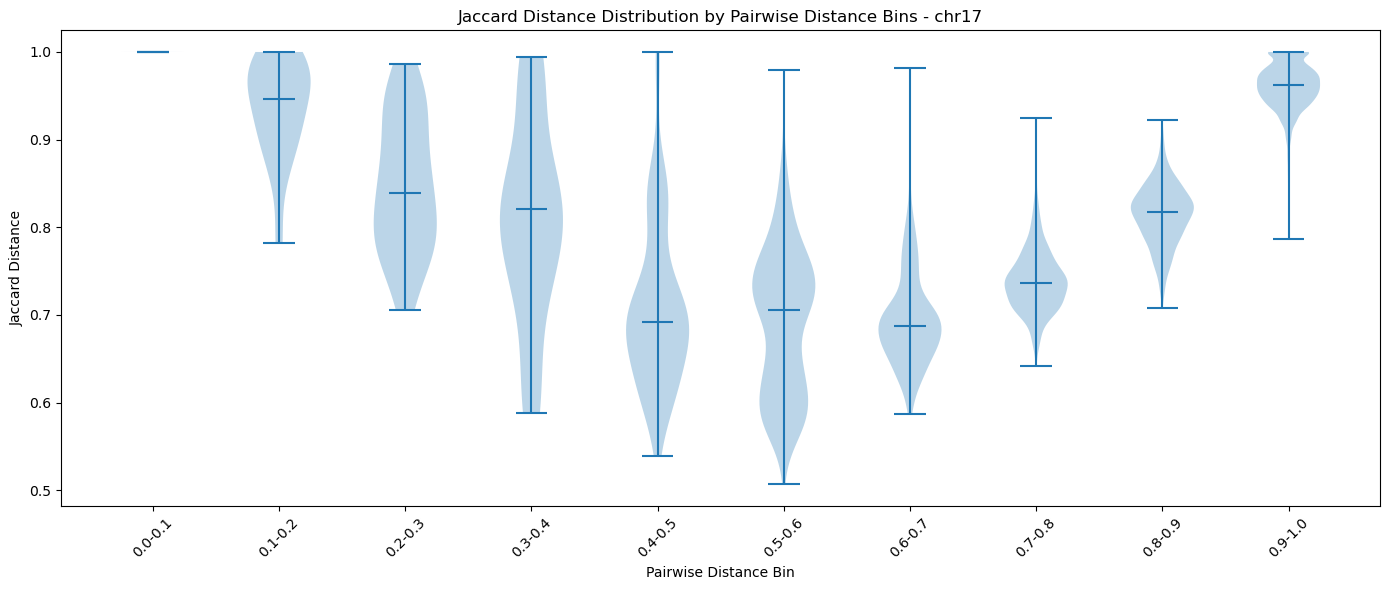

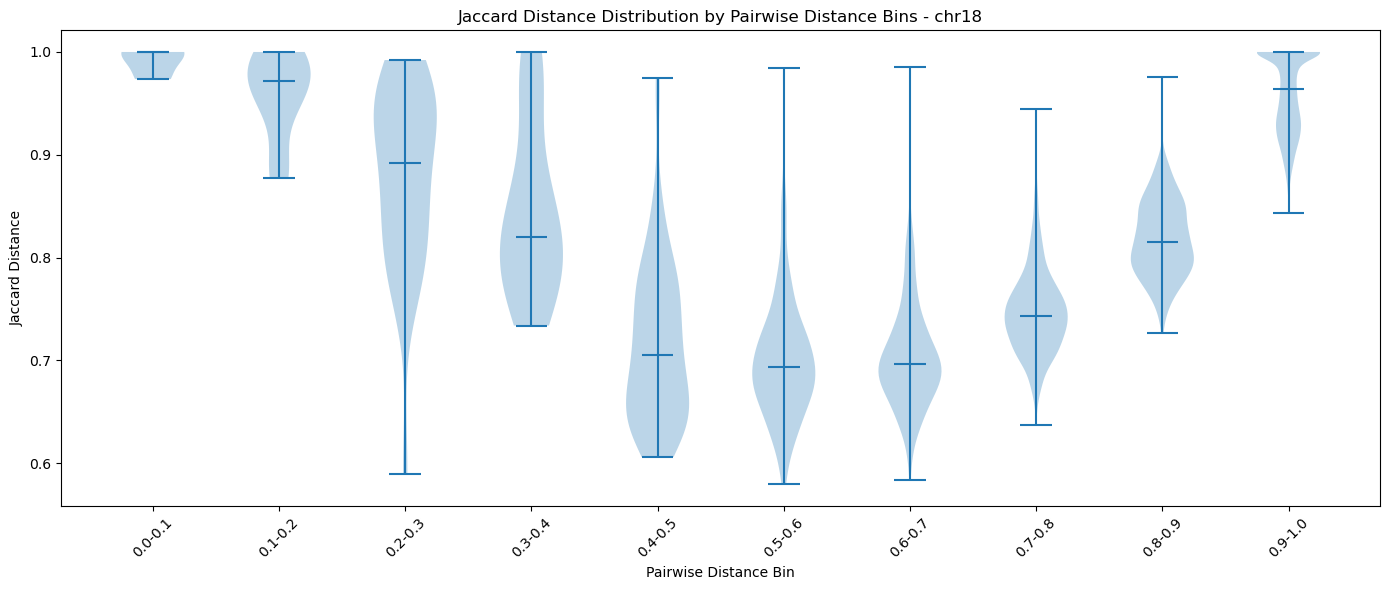

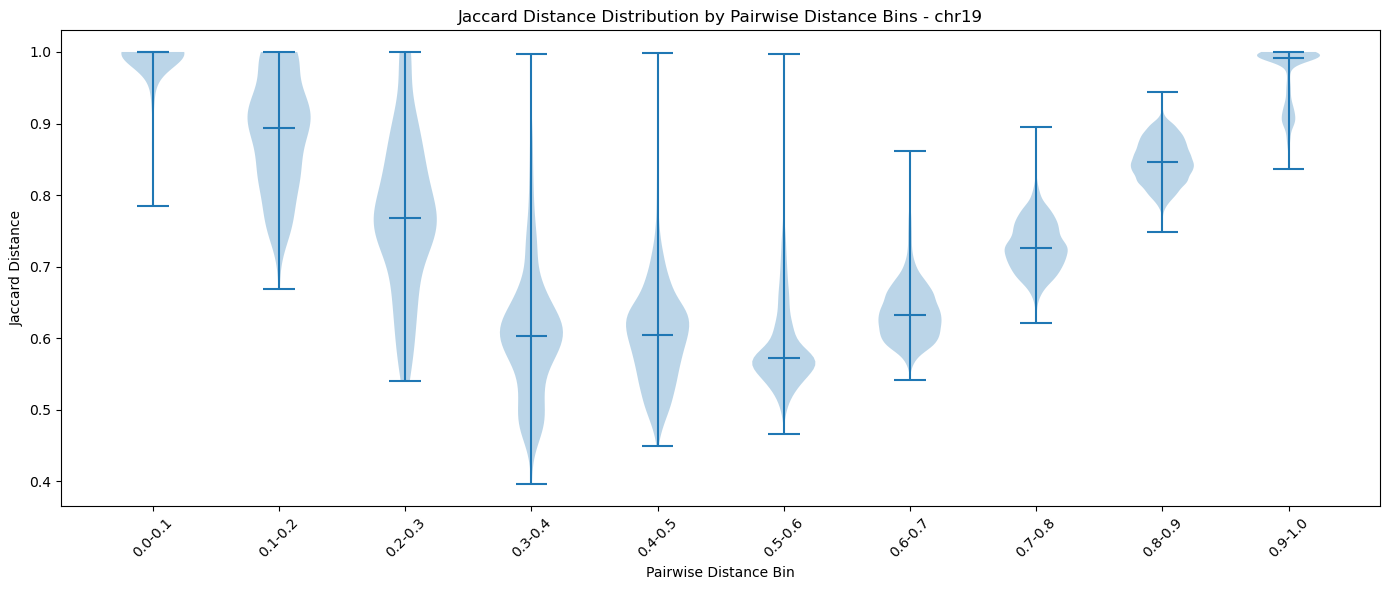

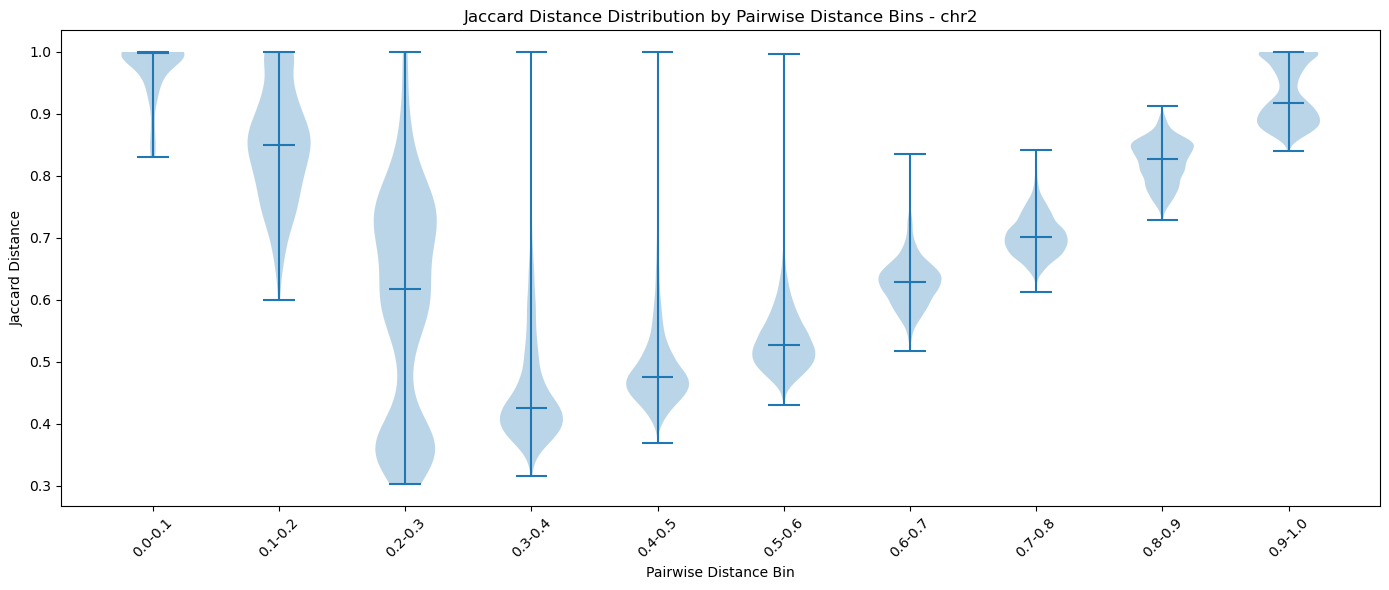

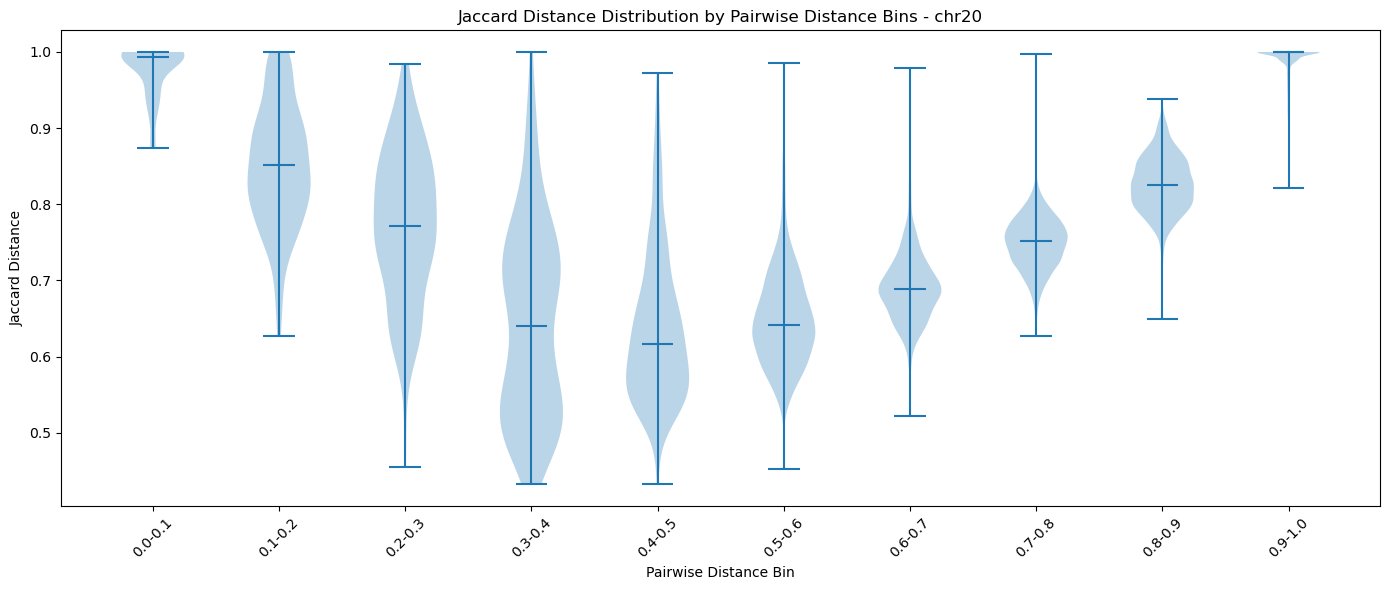

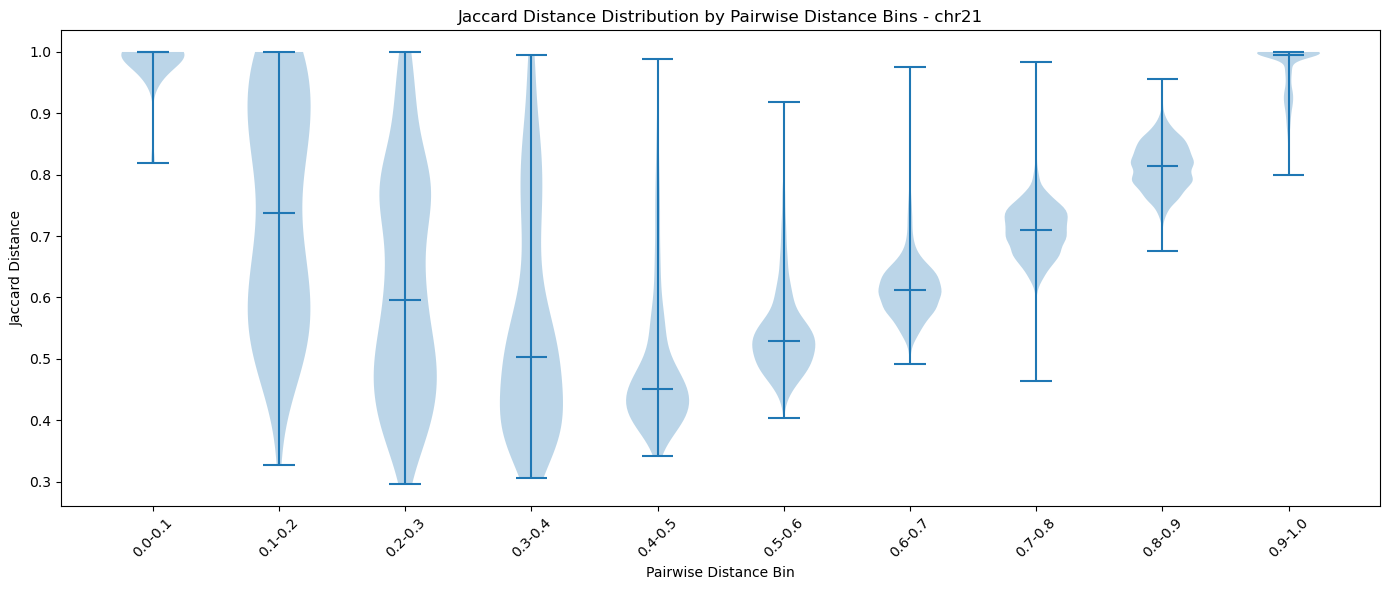

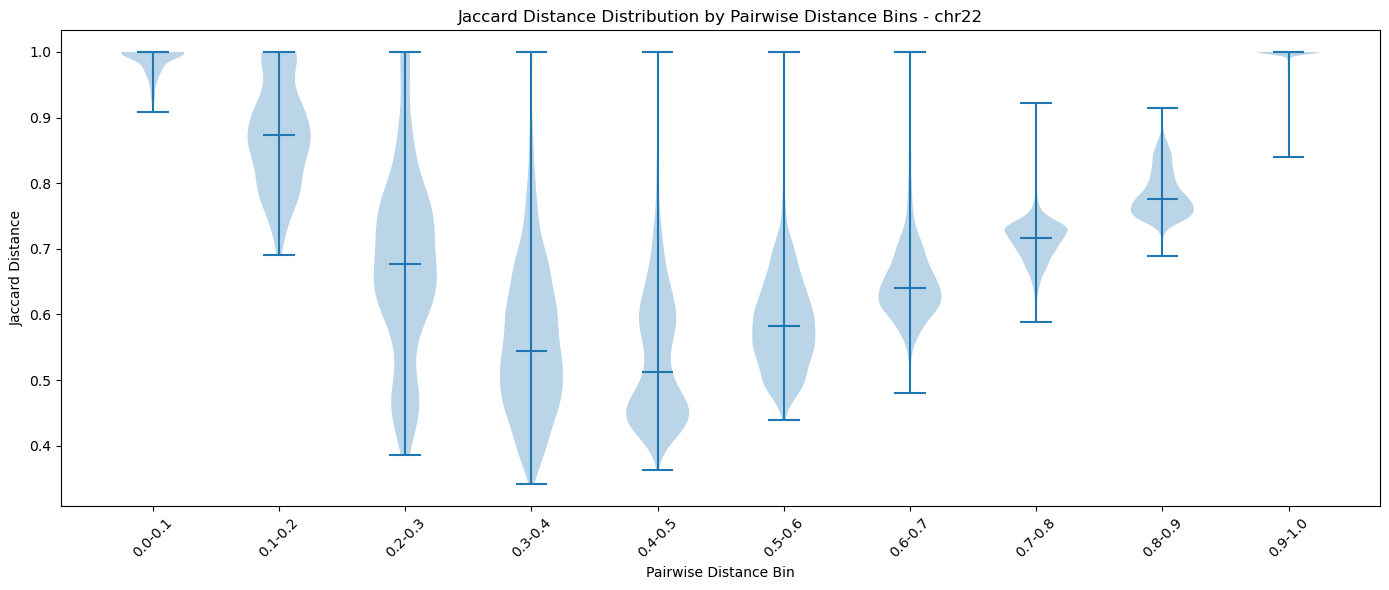

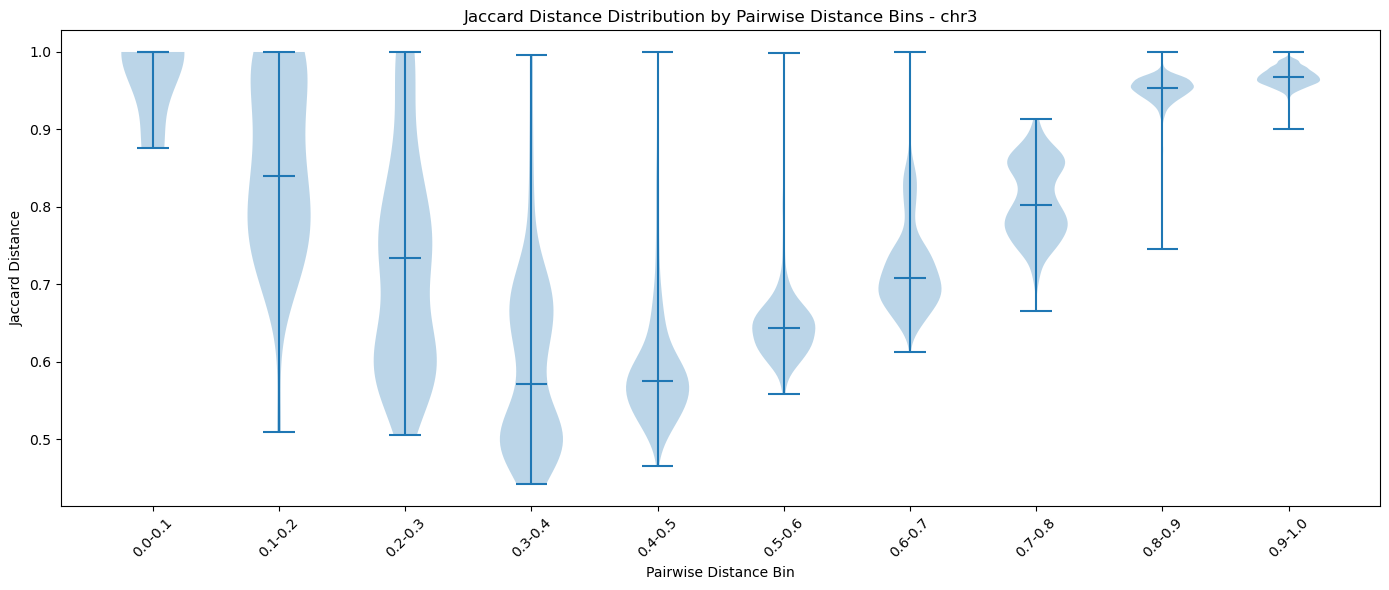

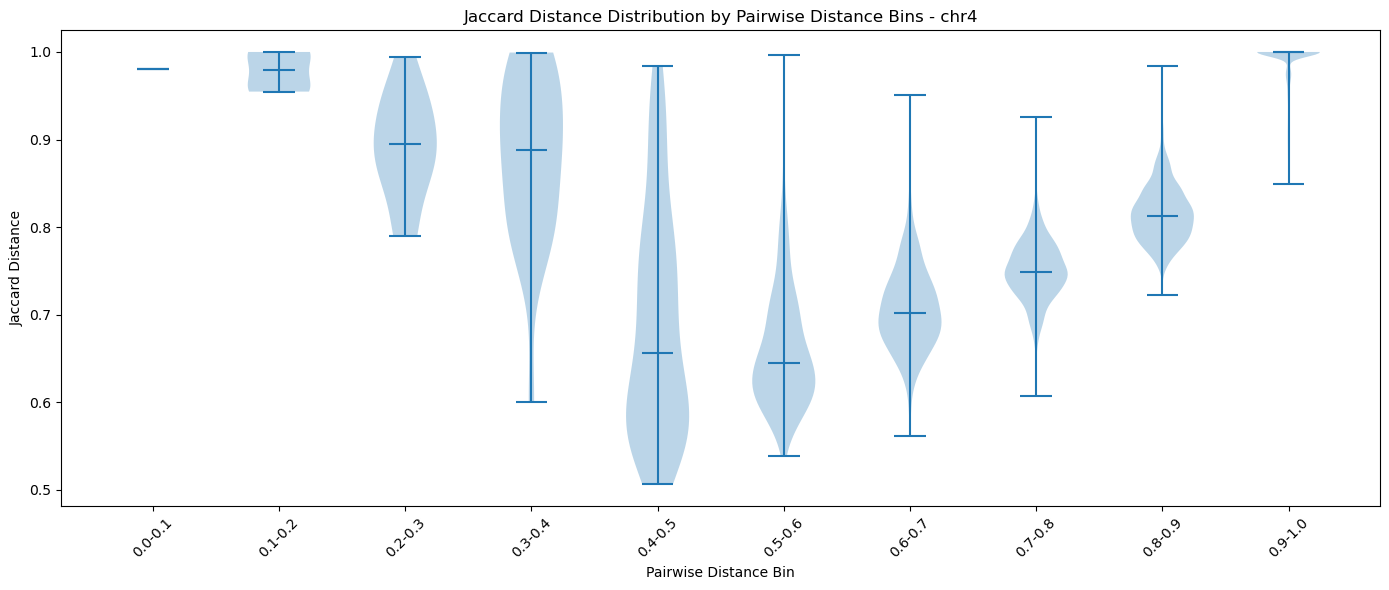

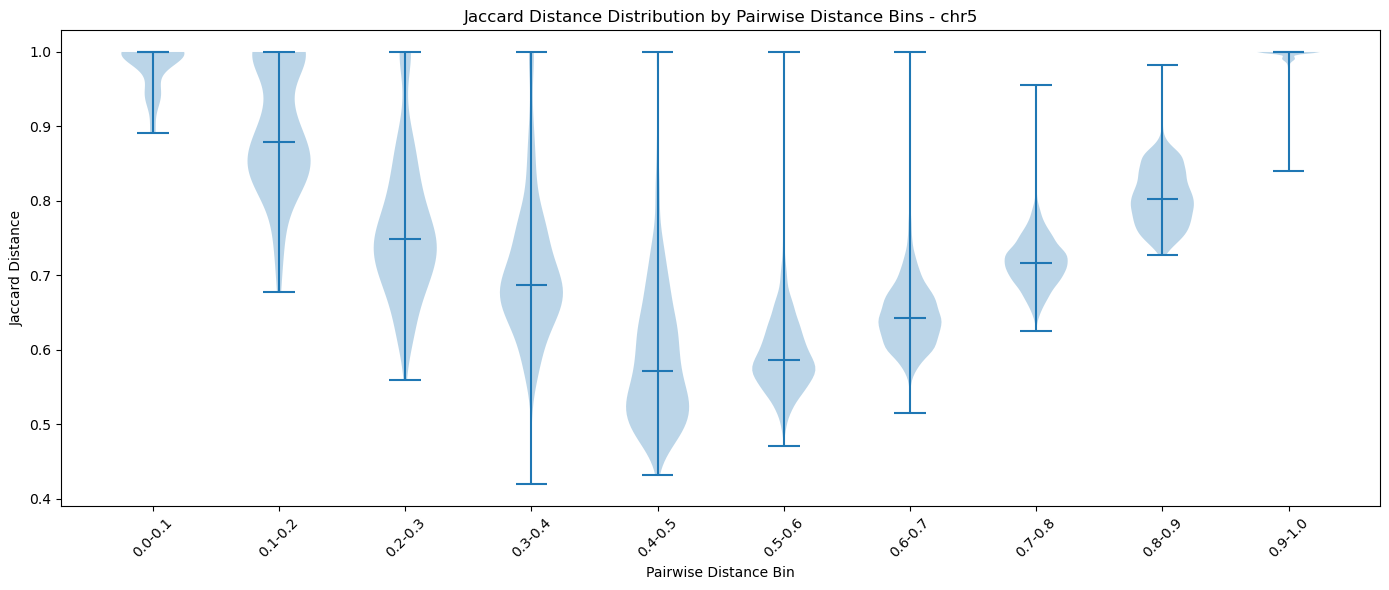

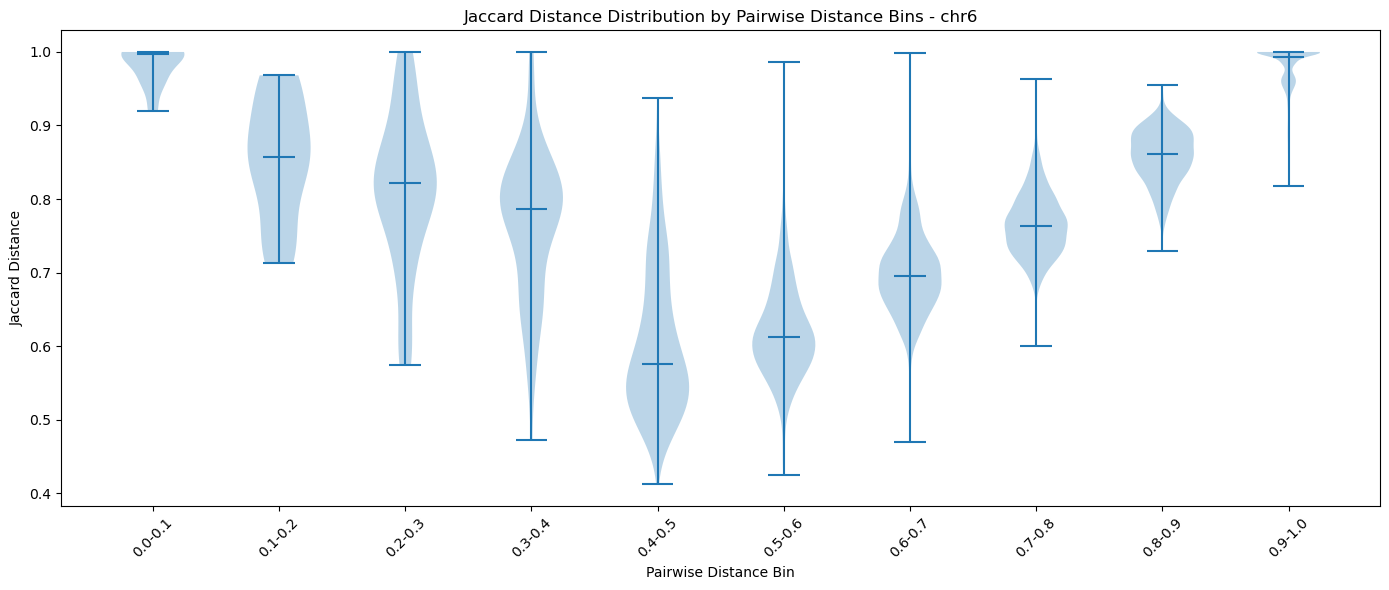

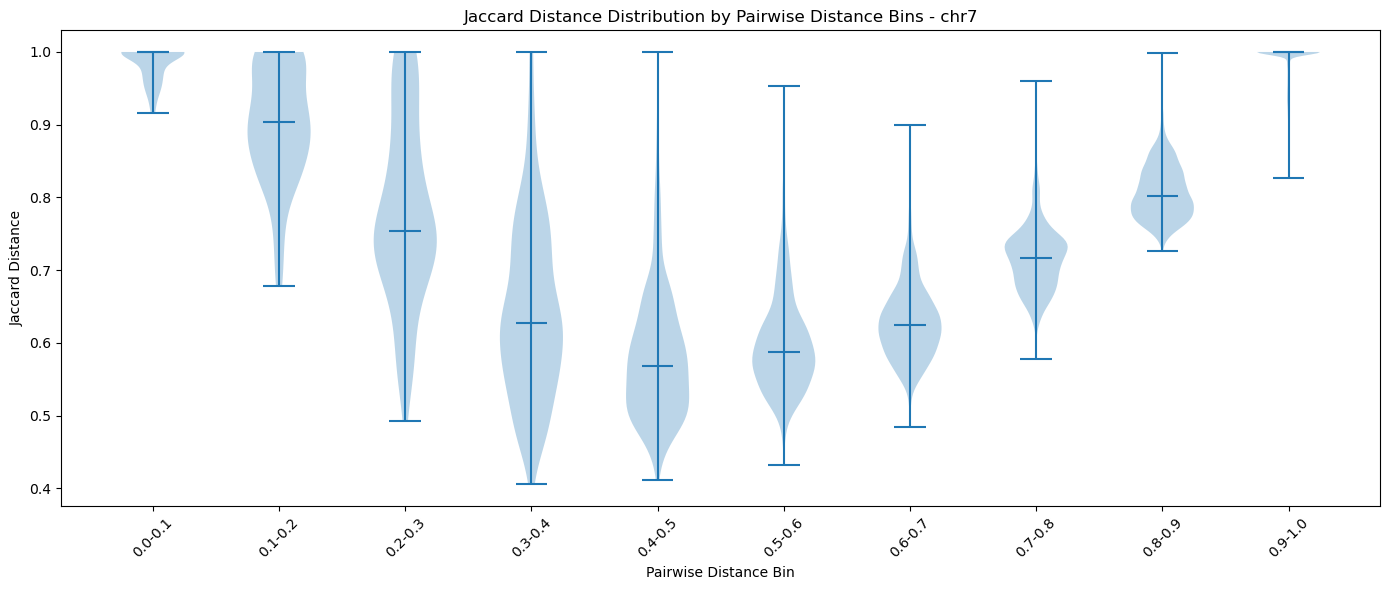

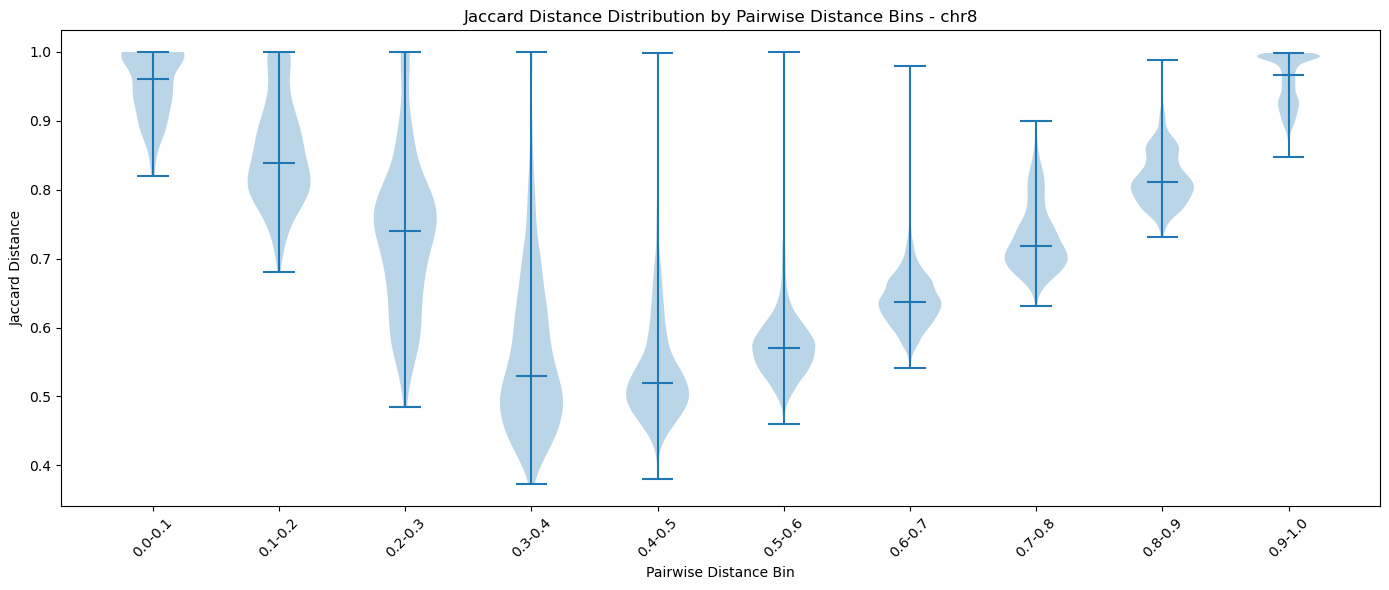

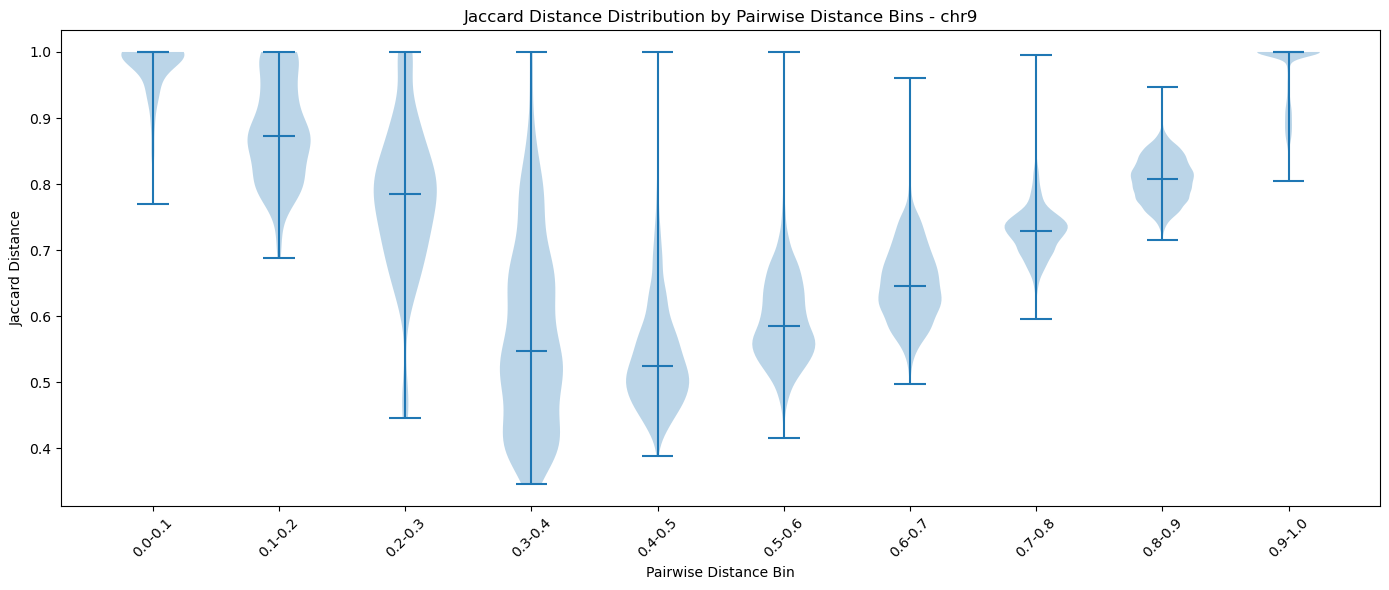

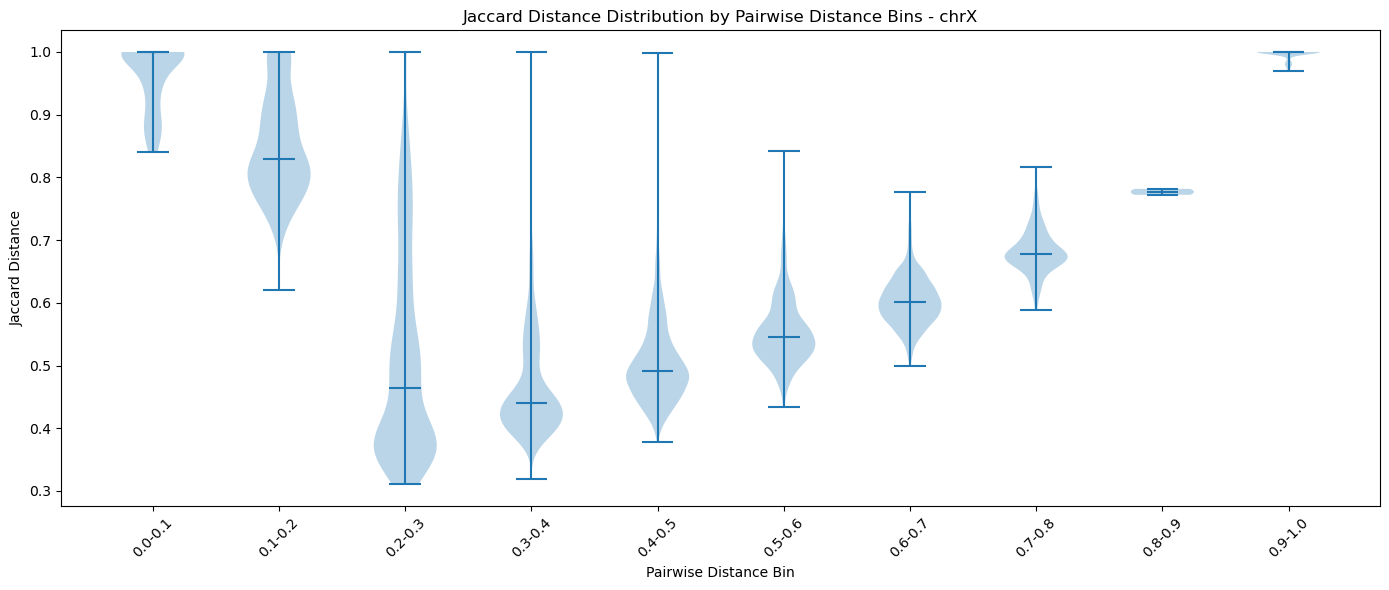

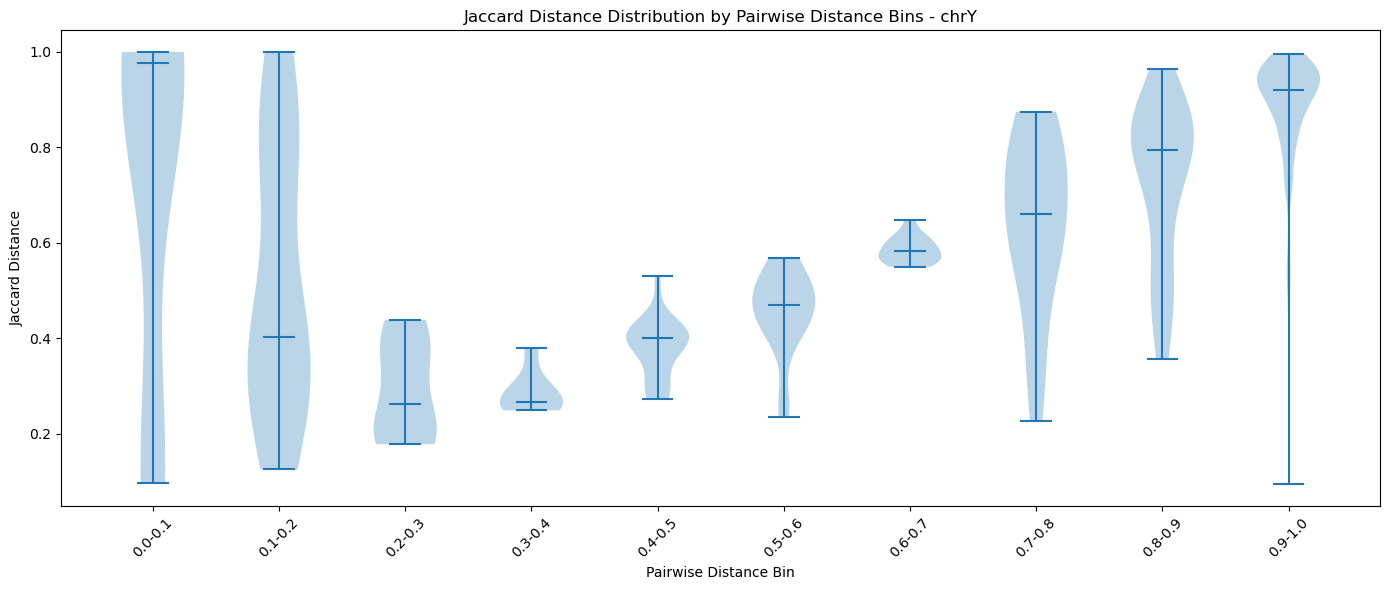

In [6]:
# Pairwise consistency histogram per chromosomes 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Define bins and labels
bins = np.arange(0, 1.1, 0.1)  # 0.0, 0.1, ..., 1.0
labels = [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(len(bins)-1)]

# Loop over chromosomes
for chrom in sorted(df["chr"].unique()):
    df_chrom = df[df["chr"] == chrom].copy()
    
    # Bin pairwise distances
    df_chrom["dist_bin"] = pd.cut(df_chrom["pairwise_dist"], bins=bins, labels=labels, include_lowest=True)
    
    # Prepare data for violin plot
    groups = [
        df_chrom.loc[df_chrom["dist_bin"] == label, "jaccard"].dropna().values
        for label in labels
    ]
    
    plt.figure(figsize=(14, 6))
    plt.violinplot(groups, showmeans=False, showmedians=True, showextrema=True)
    
    plt.xticks(range(1, len(labels) + 1), labels, rotation=45)
    plt.ylabel("Jaccard Distance")
    plt.xlabel("Pairwise Distance Bin")
    plt.title(f"Jaccard Distance Distribution by Pairwise Distance Bins - {chrom}")
    
    plt.tight_layout()
    plt.show()
